In [308]:
#-----------------------------
# Packages Import
#-----------------------------
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import os


In [309]:
#-----------------------------
# Imports a Test Image 
#-----------------------------
PathTest1= "C:\\Users\\usuario\\Desktop\\Knot-Images-to-regina-code\\data\\Test-Knot.jpg"
PathTest2= "C:\\Users\\usuario\\Desktop\\Knot-Images-to-regina-code\\data\\Test2-Knot.jpg"

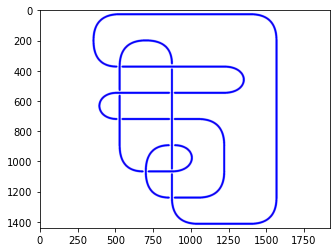

In [310]:
'''
This code will find the countours of the link as a jpg image
'''
test_image=PathTest2

image= cv2.imread(test_image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur and threshold to isolate the knot
blurred = cv2.GaussianBlur(gray, (15, 15), 0)


'''
Work which Thresholding method might be the better and more efficient for the current project
'''
_, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
#thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)


contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST , cv2.CHAIN_APPROX_SIMPLE)

image_with_countours=cv2.drawContours(image, contours, -1, (0,0,255), 5)

plt.imshow(image_with_countours)


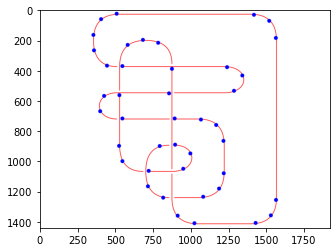

In [311]:
''' 
This clears the image
'''
image= cv2.imread(test_image)

rect_dim=[200,200]

half_w = rect_dim[0] / 2
half_h = rect_dim[1] / 2

"""
Filter points so that no two points are within the same 
rectangle defined by rect_dim (width, height).
"""
# 1. Flatten the contour to a simple list of (x, y) coordinates
points=[]
for component in contours:
    points_in_countours = [point.tolist()[0] for point in component]
    points+=points_in_countours

    
filtered_points = []
# Convert to set or list we can manipulate
remaining_points = points


while remaining_points:
    # Pick the first point in the list
    current = remaining_points.pop(0)
    filtered_points.append(current)
    
    #print(current[0])
    cx, cy = current
    
    # 2. Filter out all points that fall inside the rectangle centered at (cx, cy)
    # We use a list comprehension to keep only points OUTSIDE the box
    remaining_points = [
        p for p in remaining_points 
        if not (cx - half_w <= p[0] <= cx + half_w and 
                cy - half_h <= p[1] <= cy + half_h)
    ]

#print(contours)
#print(points[0])    


filtered_points_for_draw=np.array([[point] for point in filtered_points])

#print(filtered_points_for_draw)

image_with_fil=cv2.drawContours(image, filtered_points_for_draw, -1, (0,0,255), 25)
plt.imshow(image)

In [312]:
'''
So far we extracted the important point of the image.
The idea now is to use machine learning to move a window following the knot.
The window starts at a point of the above 
The windows moves according to the ML model 
Is is checked whether one of the important points is there, if yes it adds it to a list and records its order
otherwise continues in a while loop until it returns to the original point
If not all points were recorded that means is a link and one should do the same for the other link components

How does the window move:

The ML has 8*3*2 possible values: (N, NW, NE, E, W, S, SW, SE, over-crossing* CadinalDirection* which strands are we, under-crossing*CardinalDirection*which strand are we)
If the probability of crossing is low, then in moves acording to the probabilities obtained in the corresponding direction
If the crossing probability is high it moves in the correct crossing direction and records the over or under crossing. 

ML architecture:
The outputs are 8+8*2+8*2= 40.
The inputs are images of pixels x pixels.

'''

'\nSo far we extracted the important point of the image.\nThe idea now is to use machine learning to move a window following the knot.\nThe window starts at a point of the above \nThe windows moves according to the ML model \nIs is checked whether one of the important points is there, if yes it adds it to a list and records its order\notherwise continues in a while loop until it returns to the original point\nIf not all points were recorded that means is a link and one should do the same for the other link components\n\nHow does the window move:\n\nThe ML has 8*3*2 possible values: (N, NW, NE, E, W, S, SW, SE, over-crossing* CadinalDirection* which strands are we, under-crossing*CardinalDirection*which strand are we)\nIf the probability of crossing is low, then in moves acording to the probabilities obtained in the corresponding direction\nIf the crossing probability is high it moves in the correct crossing direction and records the over or under crossing. \n\nML architecture:\nThe out

In [326]:
'''Next goal is to create a code that generates a random sample of local knots to train the mode'''

'Next goal is to create a code that generates a random sample of local knots to train the mode'

In [327]:
#------------------------
#Basic Drawing functions:
#-----------------------

def get_boundary_point(angle, size):
    """Calculates where a line at 'angle' hits the image boundary."""
    h, w = size
    cx, cy = w // 2, h // 2
    
    # Large distance to ensure we hit the boundary
    dist = max(w, h)
    
    x1 = int(cx - dist * math.cos(angle))
    y1 = int(cy - dist * math.sin(angle))
    x2 = int(cx + dist * math.cos(angle))
    y2 = int(cy + dist * math.sin(angle))
    
    _,p1,p2 = cv2.clipLine((0, 0, w, h), (x1, y1), (x2, y2))
    return [p1,p2] 


#This function Draws a line going through the center given the angle
def draw_strand(img, angle, thickness, isMain):
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    
    p_in, p_out= get_boundary_point(angle, (h, w))
    
    cv2.line(img, p_in, p_out, (0,255,0), thickness, cv2.LINE_AA)
    if isMain: cv2.circle(img,p_in, 10, (0,255,0), -1)
    
    return None

#This function Draws an overline line going through the center given the angle
def draw_over_strand(img, angle, thickness, isMain):
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    
    p_in, p_out= get_boundary_point(angle, (h, w))
    
    cv2.line(img, p_in, p_out, (255,255,255), thickness+4, cv2.LINE_AA)
    cv2.line(img, p_in, p_out, (0,255,0), thickness, cv2.LINE_AA)
    if isMain: cv2.circle(img,p_in, 10, (0,255,0), -1)
    return None


In [328]:
#------------------
# Advanced drawing functions
#------------------


#------------------
# Constants
#----------------------
WINDOW_SIZE = (64, 64) 
THICKNESS = 2


# Mapping cardinal directions to approximate angles (in radians)
# Starting N at -90 degrees (standard Cartesian setup in image space)
DIRECTIONS = {
    "N":  -math.pi/2, "NE": -math.pi/4, "E": 0, "SE": math.pi/4,
    "S":   math.pi/2, "SW": 3*math.pi/4, "W": math.pi, "NW": -3*math.pi/4
}
DIR_KEYS = list(DIRECTIONS.keys())


#--------------------------------------------
# Drawing functions
#-----------------------------------------
def draw_Straight_Line(direction):
    #Randomize the main direction
    angle = DIRECTIONS[DIR_KEYS[direction]]+ random.uniform(-1, 1)*math.pi/16
    draw_strand(img, angle, ROPE_RADIUS * 2, True)
    return None


def draw_over_crossing(direction1, direction2):

    #Randomize a small tilt of the main picture
    angle1 = DIRECTIONS[DIR_KEYS[(direction1 + 2) % 8]]+ random.uniform(-1, 1)*math.pi/16
    angle2 = DIRECTIONS[DIR_KEYS[(direction2 + 2) % 8]]+ random.uniform(-1, 1)*math.pi/16

    # Draw secondary strand FIRST (it goes underneath)
    draw_strand(img, angle2, ROPE_RADIUS * 2, False)
    # Draw primary strand SECOND (it goes on top)
    draw_over_strand(img, angle1, ROPE_RADIUS * 2, True)

    return None


def draw_under_crossing(direction1, direction2):
        #Randomize a small tilt of the main picture
    angle1 = DIRECTIONS[DIR_KEYS[(direction1 + 2) % 8]]+ random.uniform(-1, 1)*math.pi/16
    angle2 = DIRECTIONS[DIR_KEYS[(direction2 + 2) % 8]]+ random.uniform(-1, 1)*math.pi/16

    # Draw primary strand FIRST (it goes underneath)
    draw_strand(img, angle1, ROPE_RADIUS * 2, True)
    # Draw secondart strand SECOND (it goes on top)
    draw_over_strand(img, angle2, ROPE_RADIUS * 2, False)

    return None


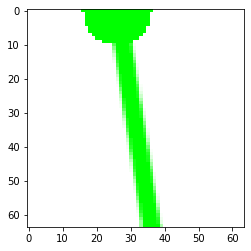

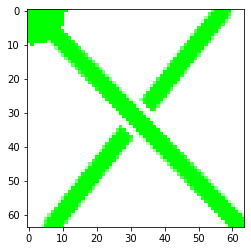

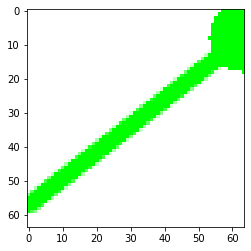

In [329]:
#-------------------------------
# Small cell that generates 5 random corssing
#-------------------------------

N=3

for i in range(N):
    # Initialize a clean, gray background
    img = np.full((WINDOW_SIZE[1], WINDOW_SIZE[0], 3), -1, dtype=np.uint8)
    
    
    # 2. Randomize the crossing type (33% No, 33% Over, 33% Under)
    cross_choice = random.random()
    main_direction, other_direction = random.sample(range(1, 7), 2)
    
    if cross_choice < 0.33:
        # State: NONE
        crossing_type = "None"
        draw_Straight_Line(main_direction) 
            
    elif cross_choice >= 0.33 and cross_choice < 0.66:
        # State: OVER-CROSSING
        crossing_type = "Over"
        draw_over_crossing(main_direction, other_direction)  
    
    else:
        # State: UNDER-CROSSING
        crossing_type = "Under"
        draw_under_crossing(main_direction, other_direction)

    plt.imshow(img)
    plt.show()
    
    


In [330]:
#-------------------------------------
# Image creation loop
#--------------------------------------

OUTPUT_DIR = "local_Knot_training_data"
NUM_IMAGES = 100 # Start with this to test



# current working directory
path = os.getcwd()
# data directory
DATA_DIR = os.path.join(path, os.pardir,'data',OUTPUT_DIR)

# Ensure output directory exists
os.makedirs( DATA_DIR, exist_ok=True)
#os.makedirs(os.path.join(data_, "images"), exist_ok=True)

for i in range(NUM_IMAGES):
    # Initialize a clean, gray background
    img = np.full((WINDOW_SIZE[1], WINDOW_SIZE[0], 3), -1, dtype=np.uint8)
    
    
    # 2. Randomize the crossing type (33% No, 33% Over, 33% Under)
    cross_choice = random.random()
    main_direction, other_direction = random.sample(range(1, 7), 2)
    
    if cross_choice < 0.33:
        # State: NONE
        crossing_type = "None"
        draw_Straight_Line(main_direction) 
            
    elif cross_choice >= 0.33 and cross_choice < 0.66:
        # State: OVER-CROSSING
        crossing_type = "Over"
        draw_over_crossing(main_direction, other_direction)  
    
    else:
        # State: UNDER-CROSSING
        crossing_type = "Under"
        draw_under_crossing(main_direction, other_direction)
    

    #Save Image and Metadata
    img_filename = f"knot_{i:05d}.jpg"
    img_path = os.path.join(DATA_DIR, img_filename)
    cv2.imwrite(img_path, img)
    
    dataset_labels.append({
        "filename": img_filename,
        "label_index": i,
        "direction": DIR_KEYS[main_direction],
        "crossing": crossing_type,
        "strand": strand_id
    })
    

# Save labels to JSON
with open(os.path.join(DATA_DIR, "labels.json"), "w") as f:
    json.dump(dataset_labels, f, indent=4)

print(f"Generated {NUM_IMAGES} synthetic images in '{OUTPUT_DIR}'")

Generated 100 synthetic images in 'local_Knot_training_data'


In [ ]:
'''General comments about the image creation. So it created only straigh lines, although close enough all lineas are roughly
straigt, it would be nice to add a functionality of the code that randimly twist and curves the generated lines.'''

In [ ]:
'''Next goal is to crate the Neural network '''